In [1]:
from src.net import EventBERTV2
from config import config
import torch
from torchinfo import summary

In [2]:
print("--- 初始化配置 ---")

print("--- 实例化 Backbone 模型 ---")
model = EventBERTV2(config)

print("\n--- 准备模拟输入数据 ---")
batch_size = 1
seq_len = config.max_seq_len # 确保 seq_len <= config.max_seq_len
input_channels = 2
input_height = 200
input_width = 200

# 模拟正负事件图像序列
# (batch_size, seq_len, C, H, W)
mock_x = torch.randn(batch_size, seq_len, input_channels, input_height, input_width)
mock_y = torch.randn(batch_size, seq_len, 7)

print("\n--- 执行模型前向传播 ---")
summary(model, input_data=[mock_x, mock_y], verbose=1)

print("\n--- 测试完成 ---")


--- 初始化配置 ---
--- 实例化 Backbone 模型 ---

--- 准备模拟输入数据 ---

--- 执行模型前向传播 ---
Layer (type:depth-idx)                             Output Shape              Param #
EventBERTV2                                        [1, 6, 3]                 --
├─EventImg2TokenV2: 1-1                            [1, 294, 768]             --
│    └─Sequential: 2-1                             [6, 1536, 7, 7]           --
│    │    └─ConvDw: 3-1                            [6, 32, 100, 100]         150
│    │    └─ConvDw: 3-2                            [6, 128, 50, 50]          4,704
│    │    └─ConvDw: 3-3                            [6, 512, 25, 25]          67,968
│    │    └─ConvDw: 3-4                            [6, 1024, 13, 13]         531,968
│    │    └─ConvDw: 3-5                            [6, 1536, 7, 7]           1,587,200
│    └─MLPSwiGLU: 2-2                              [1, 294, 768]             --
│    │    └─Linear: 3-6                            [1, 294, 4096]            6,295,552
│    │    └─Id

In [ ]:
del model
del mock_x 
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [1]:
from config import config
from src.dataset import build_dataloader

config.task = 'traj'
config.batch_size = 1

dataloader = build_dataloader(config)

# 实例化 DataLoader

print("\n--- 开始从 DataLoader 中取出一个批次的数据 ---")

# 从迭代器中获取一个批次
try:
    x_seq, traj_seq = next(iter(dataloader))
    
    print(f"成功取出一个批次！")
    print(f"x_seq 的形状: {x_seq.shape}")
    print(f"traj_seq 的形状: {traj_seq.shape}")

        
except StopIteration:
    print("错误： DataLoader 为空，无法取出数据。请检查数据集路径和内容。")


--- 开始从 DataLoader 中取出一个批次的数据 ---
成功取出一个批次！
x_seq 的形状: torch.Size([1, 24, 2, 200, 200])
traj_seq 的形状: torch.Size([1, 24, 10])


In [ ]:
import accelerate
import torch
print(accelerate.__version__)
print(torch.__version__)

a = torch.tensor([1, 2, 3], dtype=torch.bfloat16)
print(a, a.dtype)

In [ ]:
import numpy as np
import math

def KL(p,q):
    # p,q 为两个 list，表示对应取值的概率 且 sum(p) == 1 ，sum(q) == 1
    return sum(_p*math.log(_p/_q) for (_p,_q) in zip(p,q) if _p != 0 )

P = [0.2, 0.4, 0.4]
Q = [0.2, 0.4, 0.4]

print(KL(P,Q))

In [ ]:
from config import config
import torch
import torch.nn as nn
import logging
import os

from src.net import build_model

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# config.use_cuda = False

if torch.cuda.is_available() and config.use_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    torch.set_num_threads(8) 

model = build_model(config).to(device)
model.eval()

weight_path = os.path.join(config.weight_dir, "event_bert_mlm" + ".pth")
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path, map_location='cpu'), strict=False)
    logger.info(f"Loading pretrained weights from {weight_path}")
else:
    logger.warning(f"Pretrained weights not found at {weight_path}")

In [ ]:
from tqdm import tqdm

captured_outputs = []

def forward_hook(module, input, output):
    """
    一个前向钩子函数。
    每次模块(module)的forward被调用后，此函数会被触发。
    'output' 就是我们想要的 eventImg2Token 的输出结果。
    """
    # 我们将输出从GPU移到CPU并分离计算图，以防内存泄漏
    captured_outputs.append(output.detach().cpu())

target_module = model.eventImg2Token
handle = target_module.register_forward_hook(forward_hook)    

num_test_loops = 20  # 我们测试20个不同的随机输入
with torch.no_grad(): # 确保不计算梯度
    for _ in tqdm(range(num_test_loops), desc="Diagnosing Collapse"):
        # 在每次循环中创建全新的随机输入
        mock_x_pos = torch.randn(1, config.max_seq_len, 3, 200, 200) *2 -1
        mock_x_neg = torch.randn(1, config.max_seq_len, 3, 200, 200) *2 -1
        
        # 正常调用模型。当我们调用它时，钩子会自动被触发
        model(mock_x_pos.to(device), mock_x_neg.to(device), config.mask_probability)

# --- 分析捕获到的数据 ---
if captured_outputs:
    # 将所有捕获到的输出张量拼接在一起
    # 每个输出的形状是 (1, S, token_len)，拼接后是 (num_test_loops, S, token_len)
    all_outputs = torch.cat(captured_outputs, dim=0)

    # 对logits进行softmax，转换为概率分布
    all_probs = torch.softmax(all_outputs, dim=-1)

    # 计算在“样本”维度(dim=0)上的标准差
    stdev_across_samples = all_probs.std(dim=0)
    mean_stdev = stdev_across_samples.mean().item()

    logger.info(f"--- Diagnosis Result ---")
    logger.info(f"Mean Standard Deviation of softmax outputs across {num_test_loops} random inputs: {mean_stdev:.8f}")

    if mean_stdev < 1e-4: # 一个非常低的阈值
        logger.error("!!! CRITICAL: Representation Collapse DETECTED.")
        logger.info("The model produces nearly identical probability distributions for different random inputs.")
        
        # 亲眼看看证据
        logger.info("Displaying softmax probability of the first token from the first 3 random inputs:")
        for i in range(min(3, num_test_loops)):
            # 打印第一个样本，第一个token，前10个值的概率
            print(f"Random Input {i+1}: {all_probs[i, 0, :10]}...")
    else:
        logger.info("OK: No obvious sign of representation collapse. The model produces diverse outputs.")
else:
    logger.warning("Hook did not capture any outputs.")

# --- 4. 事后清理：移除钩子 ---
# 这是一个好习惯，防止钩子在后续代码中继续产生影响
handle.remove()
logger.info("Hook removed.")

del model
del mock_x_pos
del mock_x_neg 
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

num_vectors = all_outputs.size(0) * all_outputs.size(1)
token_dimension = all_outputs.size(2)

all_vectors_flat = all_outputs.view(num_vectors, token_dimension)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne(vectors: torch.Tensor):
    """
    使用t-SNE对向量进行二维可视化。
    """
    logger.info("--- t-SNE Visualization ---")
    logger.info("Running t-SNE... this may take a moment.")
    
    # t-SNE需要numpy数组
    vectors_np = vectors.cpu().numpy()
    
    tsne = TSNE(n_components=2, perplexity=15, learning_rate='auto', init='random')
    vectors_2d = tsne.fit_transform(vectors_np)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6)
    plt.title("t-SNE Visualization of Output Vectors")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    # 保存图像而不是显示
    # plt.savefig("tsne_visualization.png")
    # logger.info("t-SNE visualization saved to tsne_visualization.png")

visualize_tsne(all_vectors_flat)

In [ ]:
import torch
import torch.nn.functional as F

def analyze_cosine_similarity(vectors: torch.Tensor):
    """
    分析一批向量的平均余弦相似度。
    Args:
        vectors (torch.Tensor): 形状为 (N, D) 的向量，N是样本数，D是向量维度。
    """
    # 1. 对向量进行L2归一化
    vectors_normalized = F.normalize(vectors, p=2, dim=1)
    
    # 2. 计算所有成对的余弦相似度
    # (N, D) x (D, N) -> (N, N) 的相似度矩阵
    cosine_matrix = torch.matmul(vectors_normalized, vectors_normalized.t())
    
    # 3. 提取上三角部分（不包括对角线），计算平均值
    # 对角线上的值总是1（自己和自己的相似度），需要排除
    N = vectors.size(0)
    # 创建一个上三角掩码
    mask = torch.triu(torch.ones(N, N), diagonal=1).bool()
    # 提取所有成对相似度值
    pairwise_similarities = cosine_matrix[mask]
    
    # 4. 计算平均值和标准差
    avg_cosine_sim = pairwise_similarities.mean().item()
    std_cosine_sim = pairwise_similarities.std().item()

    logger.info(f"--- Cosine Similarity Analysis ---")
    logger.info(f"Average pairwise cosine similarity: {avg_cosine_sim:.6f}")
    logger.info(f"Std dev of cosine similarity: {std_cosine_sim:.6f}")

    if avg_cosine_sim > 0.99: # 设置一个非常高的阈值
        logger.error("!!! CRITICAL: Representation Collapse DETECTED via Cosine Similarity.")
        logger.error("Vectors are pointing in nearly the same direction.")
    else:
        logger.info("OK: Cosine similarity analysis shows no sign of collapse.")

analyze_cosine_similarity(all_vectors_flat)

In [1]:
import torch
from torch.autograd import Variable
from transformers.optimization import get_scheduler
import matplotlib.pyplot as plt

tensor([[5.0261]], requires_grad=True)


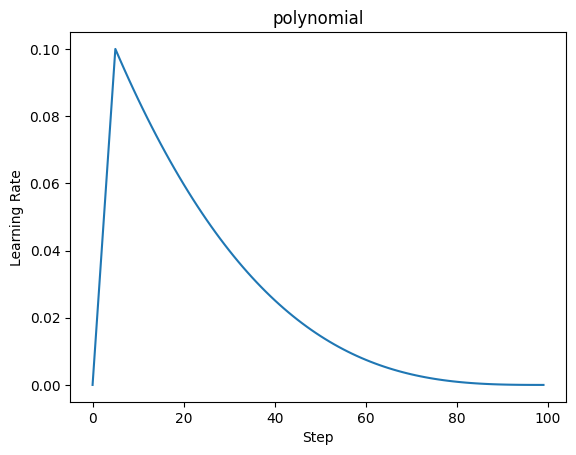

In [5]:

# from accelerate import Accelerator

tensor = torch.FloatTensor([[4]]) # build a tensor
x = Variable(tensor, requires_grad=True) # build a variable, usually for compute gradients

scheduler_name = 'polynomial'
scheduler_specific_kwargs = {}
if scheduler_name == 'cosine_with_restarts':
    scheduler_specific_kwargs = {
        'num_cycles': 2,
    }
elif scheduler_name == 'cosine_with_min_lr':
    scheduler_specific_kwargs = {
        'min_lr': 0.1
    }
elif scheduler_name == 'polynomial':
    scheduler_specific_kwargs = {
        'power': 3.0
    }
steps = 100
warmup = 0.05
optimizer2 = torch.optim.Adam([x], lr=0.1)
scheduler2 = get_scheduler(
        name=scheduler_name,
        optimizer=optimizer2,
        num_warmup_steps=int(steps*warmup),
        num_training_steps=steps,
        scheduler_specific_kwargs=scheduler_specific_kwargs
)

learning_rates2 = []

for step in range(steps):
    learning_rates2.append(optimizer2.param_groups[0]['lr'])

    optimizer2.zero_grad()
    outputs2 = torch.pow((x - 5), 2)
    loss2 = outputs2
    loss2.backward()
    optimizer2.step()
    scheduler2.step()

print(x)

# Plotting the learning rates
plt.plot(range(steps), learning_rates2)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title(scheduler_name)
plt.show()

In [2]:
import torch
from config import config
import os
weight_path = os.path.join(config.weight_dir, "event_bert_mlm.pth")
state_dict = torch.load(weight_path, map_location='cpu')

In [ ]:
for param in state_dict:
        #打印 key value字典
        print(param,'\t',state_dict[param].size())

In [1]:
from transformers import Dinov2Config, Dinov2Model

# Initializing a Dinov2 dinov2-base-patch16-224 style configuration
configuration = Dinov2Config()

# Initializing a model (with random weights) from the dinov2-base-patch16-224 style configuration
model = Dinov2Model(configuration)

print(model)

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x


class Encoder(nn.Module):
    """
    This is the q_theta (z|x) network. Given a data sample x q_theta 
    maps to the latent space x -> z.

    For a VQ VAE, q_theta outputs parameters of a categorical distribution.

    Inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack

    """

    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)

In [4]:
# random data
x = np.random.random_sample((1, 3, 200, 200))
x = torch.tensor(x).float()
# test Residual Layer
res = ResidualLayer(3, 3, 20)
res_out = res(x)
print('Res Layer out shape:', res_out.shape)
# test res stack
res_stack = ResidualStack(3, 3, 20, 3)
res_stack_out = res_stack(x)
print('Res Stack out shape:', res_stack_out.shape)

Res Layer out shape: torch.Size([1, 3, 200, 200])
Res Stack out shape: torch.Size([1, 3, 200, 200])


In [3]:
x = np.random.random_sample((1, 3, 200, 200))
x = torch.tensor(x).float()

# test encoder
encoder = Encoder(3, 128, 3, 64)
encoder_out = encoder(x)
print('Encoder out shape:', encoder_out.shape)

Encoder out shape: torch.Size([1, 128, 50, 50])
